In [1]:
import csv, math
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from scipy import signal
from scipy.optimize import leastsq

from scipy.fftpack import fft

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def linear_fit(x, y):
    # y = a + bX
    
    # b
    x_hat = np.mean(x)
    y_hat = np.mean(y)
    b = ( np.sum((x-x_hat) * (y-y_hat)) ) / np.sum((x-x_hat)**2) 

    # a
    a = y_hat - (b*x_hat)

    return a, b

def lp_filter(sig, cutoff=0.3, fs=25, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    y = signal.lfilter(b, a, sig)
    return y

def delin(y):
    x = np.array(range(0,len(y)))
    a,b = linear_fit(x,y)
    return y-(a+b*x)

def normalize(y, fit=False, lowpass=False):
    x = np.array(range(0,len(y)))
    y = 2 * ( (y - np.min(y)) / (np.max(y) - np.min(y)) ) - 1
    return y

def rms(y):
    return np.sqrt(np.mean(y**2))    

def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')

def plot_bland_altman(data1, data2, title):
    min_len = min(len(data1), len(data2))
    bland_altman_plot(data1[:min_len], data2[:min_len])
    plt.title('Pressure/Gt')

In [3]:
df = pd.read_csv('events/normal_breathing_4.csv')
df_temp = df.where(df['type'] == 'temperature').dropna()
df_pressure = df.where(df['type'] == 'pressure').dropna()
df_gt = pd.read_csv('events/normal_breathing_4_gt.csv')

In [4]:
# pressure: remove linear trend and normalize
df_pressure['filtered_value'] = normalize(delin(df_pressure['value']))
df_pressure['lowpass_filter'] = lp_filter(df_pressure['filtered_value'])
 
# temperature: remove linear trend, normalize and invert
df_temp['filtered_value'] = normalize(delin(df_temp['value']))
df_temp['lowpass_filter'] = lp_filter(df_temp['filtered_value'])

# ground truth: normalize and invert
df_gt['filtered_value'] = -normalize(df_gt['Arb'])



df_gt.head(100)

,Time,Arb,filtered_value
0,'-0:0:0.63,796,-0.403950
1,'-0:0:0.62,798,-0.411131
2,'-0:0:0.61,799,-0.414722
3,'-0:0:0.6,800,-0.418312
4,'-0:0:0.59,800,-0.418312
...,...,...,...
95,'0:0:0.32,954,-0.971275
96,'0:0:0.33,954,-0.971275
97,'0:0:0.34,953,-0.967684
98,'0:0:0.35,952,-0.964093


In [5]:
# convert to datetime
df_temp['datetime'] = pd.to_datetime(df_temp['datetime'], infer_datetime_format=True)
df_pressure['datetime'] = pd.to_datetime(df_pressure['datetime'], infer_datetime_format=True)

In [6]:

# offset to line up the peaks... eye ball method
offset = timedelta(seconds=-1)

# set timestamps
startdate = df_pressure.iloc[0]['datetime'] - offset

def dt_ti(time_str):
    time_str = time_str.replace("'", '')
    spt = time_str.split(':')
    h = int(spt[0])
    m = int(spt[1])
    s = float(spt[2])
    delta = timedelta(hours=h, minutes=m, seconds=s)
    return delta


df_gt['timedelta'] = df_gt['Time'].apply(dt_ti)
df_gt['datetime'] = startdate + df_gt['timedelta']
df_gt.head()

,Time,Arb,filtered_value,timedelta,datetime
0,'-0:0:0.63,796,-0.403950,0 days 00:00:00.630000,2021-02-09 17:10:08.667
1,'-0:0:0.62,798,-0.411131,0 days 00:00:00.620000,2021-02-09 17:10:08.657
2,'-0:0:0.61,799,-0.414722,0 days 00:00:00.610000,2021-02-09 17:10:08.647
3,'-0:0:0.6,800,-0.418312,0 days 00:00:00.600000,2021-02-09 17:10:08.637
4,'-0:0:0.59,800,-0.418312,0 days 00:00:00.590000,2021-02-09 17:10:08.627


In [7]:
# adjust phase shift for temp
temp_delta = timedelta(seconds=3)
df_temp['datetime_shift'] = df_temp['datetime'] - temp_delta

In [8]:
# trim times windows (eye balled a window where all signals start and end)
start = datetime(2021, 2, 9, 17, 10, 10, 0)
end = datetime(2021, 2, 9, 17, 10, 34, 0)

df_pressure_trim = df_pressure.where(df_pressure['datetime'] > start).where(df_pressure['datetime'] < end)
df_temp_trim = df_temp.where(df_temp['datetime_shift'] > start).where(df_temp['datetime_shift'] < end)
df_gt_trim = df_gt.where(df_gt['datetime'] > start).where(df_gt['datetime'] < end)

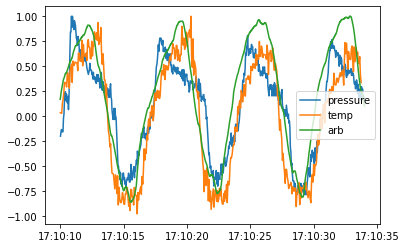

In [9]:
# plot raw signals
plt.plot(df_pressure_trim['datetime'], df_pressure_trim['filtered_value'], label='pressure')
plt.plot(df_temp_trim['datetime_shift'], df_temp_trim['filtered_value'], label='temp')
plt.plot(df_gt_trim['datetime'], df_gt_trim['filtered_value'], label='arb')

plt.legend()

In [10]:
# resample the signals for bland altman plot (smaller sample in order to read the plot better)
period = '250ms'
df_pressure_resampled = df_pressure_trim.resample(period, on='datetime').mean()
df_temp_resampled = df_temp_trim.resample(period, on='datetime_shift').mean()
df_gt_resampled = df_gt_trim.resample(period, on='datetime').mean()

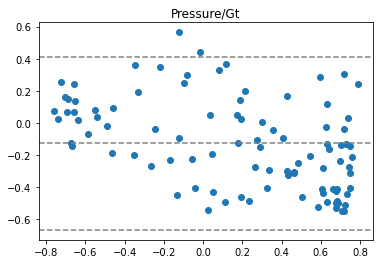

In [11]:
# compare temp and ground truth
plot_bland_altman(df_pressure_resampled['filtered_value'], df_gt_resampled['filtered_value'], 'Temp/Gt')

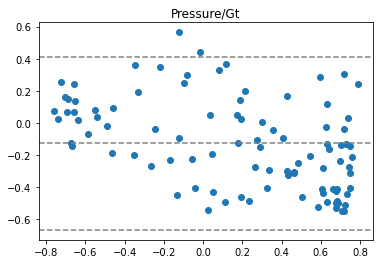

In [14]:
# compare pressure and ground truth
plot_bland_altman(df_pressure_resampled['filtered_value'], df_gt_resampled['filtered_value'], 'Pressure/Gt')


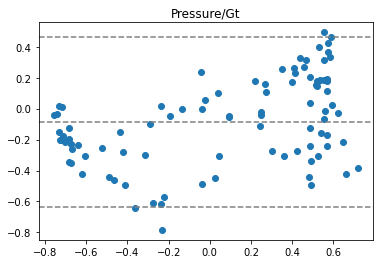

In [13]:
# compare temp and pressure
plot_bland_altman(df_temp_resampled['filtered_value'], df_pressure_resampled['filtered_value'], 'Temp/Pressure')